# Comparing a USGSCSM and ISIS camera for Kaguya Terrain Camera

In [1]:
import pvl
import os
import tempfile
import csmapi
import json

os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"

import knoten
import ale
from knoten import vis
from ale.drivers.selene_drivers import KaguyaTcPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale import util
from IPython.display import Image
from pysis import isis
from pysis.exceptions import ProcessError

import plotly
plotly.offline.init_notebook_mode(connected=True)

/home/kberry/anaconda3/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning: ALESPICEROOT environment variable not set, Spice Drivers will not function correctly
  warnings.warn('ALESPICEROOT environment variable not set, Spice Drivers will not function correctly')


## Make a CSM sensor model
Requires TC1S2B0_01_02842S506E1942.img in data directory

In [2]:
fileName = 'data/TC1S2B0_01_02842S506E1942.img'
camera = knoten.csm.create_csm(fileName)

## Ingest the image and spiceinit

In [3]:
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.kaguyatc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)    
    
try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
kernels = util.generate_kernels_from_cube(cub_loc, expand=True)

usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter='usgscsm', verbose=False)

csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)    

## Compare USGS CSM and ISIS pixels

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

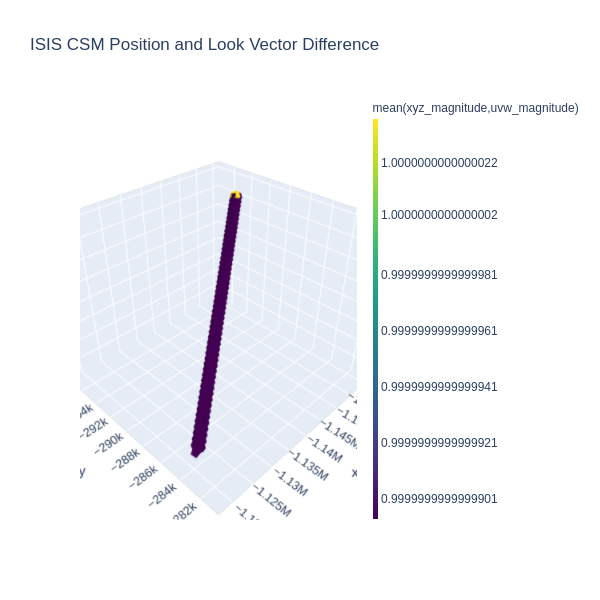

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

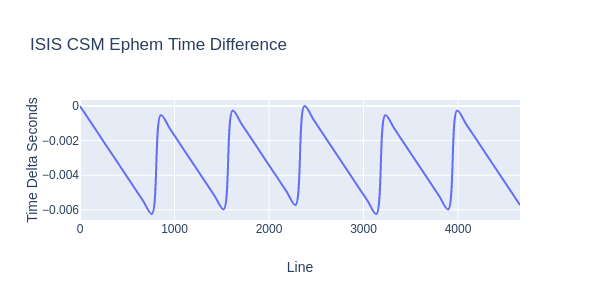

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,5.000000e+02,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000
mean,-3.764518e+00,-1.048220e+00,3.332081e+00,-0.000011,-0.000053,0.000035
std,2.266309e+00,6.310266e-01,2.002696e+00,0.000015,0.000004,0.000021
min,-7.554348e+00,-2.102804e+00,-1.883600e-07,-0.000039,-0.000061,-0.000002
25%,-5.660647e+00,-1.575851e+00,1.665026e+00,-0.000024,-0.000057,0.000017
50%,-3.748460e+00,-1.044270e+00,3.352137e+00,-0.000011,-0.000053,0.000036
75%,-1.861556e+00,-5.189632e-01,5.061536e+00,0.000001,-0.000050,0.000054
max,1.539011e-07,4.379544e-07,6.740310e+00,0.000016,-0.000045,0.000073


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

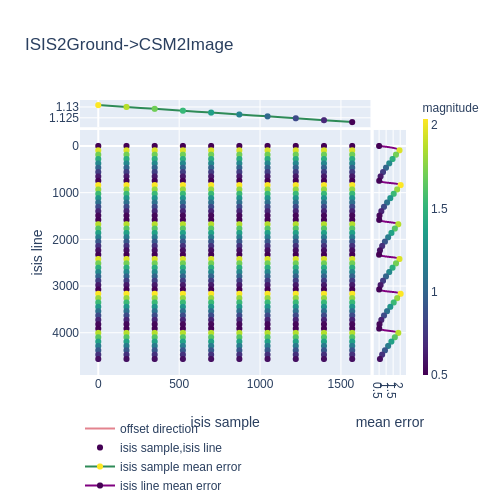

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.941768,0.499333
std,0.617978,0.008042
min,-1.970215,0.474244
25%,-1.455668,0.495232
50%,-0.941320,0.499872
75%,-0.427245,0.504063
max,0.085581,0.521046


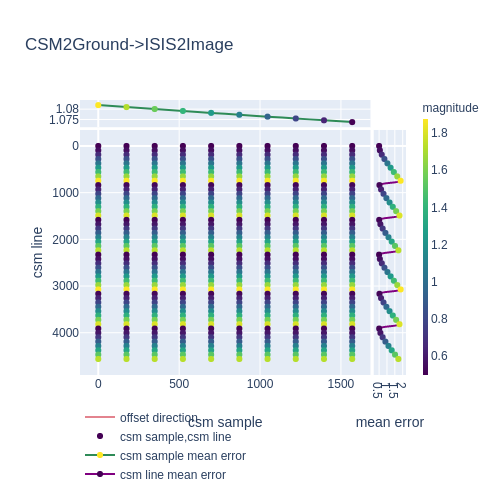

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.901014,-0.499347
std,0.542037,0.007483
min,-0.002196,-0.519806
25%,0.450390,-0.503457
50%,0.900862,-0.499462
75%,1.351769,-0.495036
max,1.801945,-0.479093


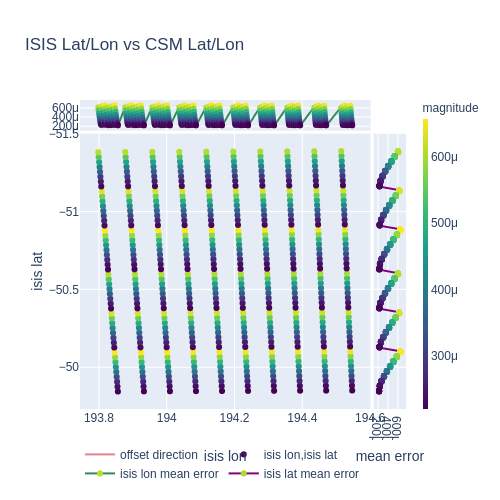

In [13]:
Image(isiscsm_plotlatlon.to_image())

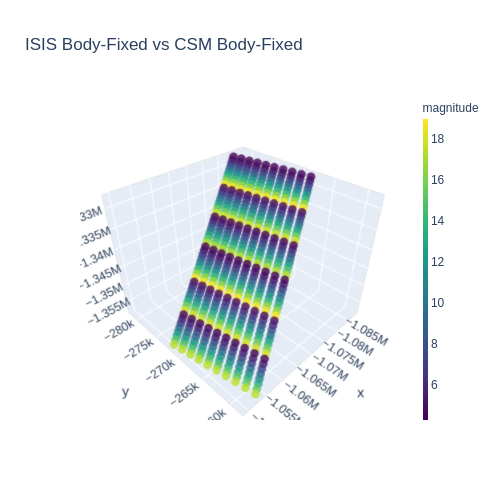

In [14]:
Image(isiscsm_plotbf.to_image())

In [15]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,-0.666700,6.074421,-5.791857
std,0.279666,1.152411,3.505313
min,-0.985789,4.158460,-11.758735
25%,-0.895662,5.060177,-8.812710
50%,-0.765377,6.067642,-5.828931
75%,-0.511609,7.061852,-2.872202
max,0.015197,8.166681,0.063292
